# Overview

Create a simple baseline model to compare more advanced methods against.

### Ideas based on EDA

**Categorical variables as primary predictors:**
- Take one or a combination of variables and calculate the average salary per category

Predicting salaries on new data will involve using stored fitted values that were calculated on training data. The fitted values for categorical variables will simply be the grouped averages. Later the new data will have these averages joined to it, by using the group of categorical variables as the key.


**Numerical variables as additive predictors:**

The baseline model will require at least one categorical variable. Models using just a numerical variable for prediction will not be tested here. To illustrate why this decision was made, consider taking the average salary of all jobs within 1 `milesFromMetropolis`, for example. This will include a mixture of all different levels of `jobTypes` and will likely not give a good estimate. Because the average value would be taking into account roles ranging from `JANITOR` to `CEO`.

Instead, the way the these numerical variables will be factored into the predictions is by looking at how different the grouped averages are from the overall average. The salary that is predicted by the categorical variable is shifted based on this difference. Hopefully this will help the baseline model better distinguish between varying levels of experience for the same job category.

There is a manageable number of unique values that either `yearsExperience` or `milesFromMetropolis` can take on, but this approach would not be scalable to a wide range of continuous values (at least without some discretization).

___

_For example_

- We know from EDA that:
    - 116k - Avg. salary overall
    -  92k  - Avg. salary salary for jobs with 0 `yearsExperience` - _(24k lower than overall average)_
    - 140k - Avg. salary salary for jobs with 24 `yearsExperience` - _(24k higher than overall average)_  

- When predicting the salary for a `jobType` of `MANAGER` with 0 `yearsExperience`:
    1. 115k starting point - the grouped categorical average for managers, in this case
    2. We can expect the prediction to be 24k lower than the average `MANAGER`'s salary 
    3. The final salary prediction is then 91k  
        a. conversely, a manager with 24 `yearsExperience` will have the expected salary bumped up by 24k to 139k
        

___

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

from src.Baseline import BaselineModel, SelectBestModel
from src.baseline_utils import visualize_numeric_fit

# Load data

In [2]:
train_salaries = pd.read_csv("../data/interim/salaries_train_85_15_split.csv", index_col = 0)
test_salaries = pd.read_csv("../data/interim/salaries_test_85_15_split.csv", index_col = 0)

print(f"training set shape: {train_salaries.shape}")
print(f"test set shape: {test_salaries.shape}")

training set shape: (849995, 8)
test set shape: (150000, 8)


# Example baseline model to illustrate functionality

## Fitting the model

The model is instantiated with `BaselineModel()` and is fit using the `.fit()` method, passing in a dataframe.

- args:
    + category_vars (required): String or list of strings of categorical variables
    + numeric_vars (optional): String or list of strings of numerical variables
    + id_var (optional): Name of the ID column - set to 'jobId' by default
    + target (optional): Name of the target variable - set to 'salary' by default 

In [3]:
example_baseline = BaselineModel(category_vars='jobType', numeric_vars=['yearsExperience', 'milesFromMetropolis'])
example_baseline.fit(train_salaries)

#### Fitted categorical values

- Stored as a dataframe with one column: `salary_preds`  
- The index is the grouping variable used for calculating the average salary
    + For multiple categorical variables the index will be multi-leveled

In [4]:
example_baseline.fitted_category_salaries

,salary_preds
jobType,
JANITOR,70.785181
JUNIOR,95.341564
SENIOR,105.405757
MANAGER,115.419110
VICE_PRESIDENT,125.390156
CFO,135.441672
CTO,135.485534
CEO,145.364115


#### Fitted numerical values

- Stored as a dictionary with a key for each numerical column that was used for fitting  
- The value of each key contains a Series that represents, for each unique value, the difference between the average salary of that value and the overall average salary 

In [5]:
example_baseline.fitted_numeric_diffs

{'yearsExperience': yearsExperience
 0    -24.173570
 1    -22.052242
 2    -19.969124
 3    -18.064561
 4    -16.023098
 5    -14.395663
 6    -12.127425
 7     -9.997218
 8     -8.301810
 9     -5.921390
 10    -3.938727
 11    -2.166129
 12     0.444267
 13     1.857557
 14     4.233491
 15     5.923825
 16     8.032665
 17     9.979064
 18    12.310572
 19    13.831090
 20    16.160942
 21    18.112413
 22    20.266673
 23    22.328628
 24    24.114106
 Name: yearsExperience_diff, dtype: float64,
 'milesFromMetropolis': milesFromMetropolis
 0     19.276701
 1     19.659869
 2     19.054796
 3     18.436109
 4     18.819768
         ...    
 95   -18.044574
 96   -18.752739
 97   -18.601879
 98   -18.841883
 99   -20.292592
 Name: milesFromMetropolis_diff, Length: 100, dtype: float64}

##### Visualizing the numeric fitted values

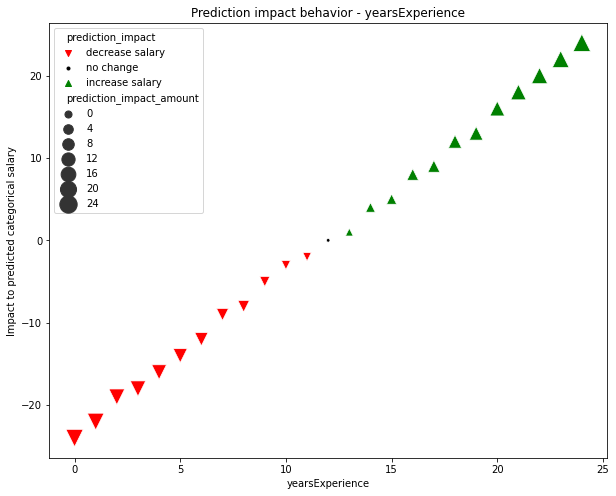

In [6]:
visualize_numeric_fit(example_baseline.fitted_numeric_diffs['yearsExperience'])

The chart shows the behavior of the model, with respect to the `yearsExperience` variable.

Values close to 12 `yearsExperience` will have little to no impact on the final salary amount. Values close to 0 or 24 will decrease or increase the predicted salary amount by the most, respectively.

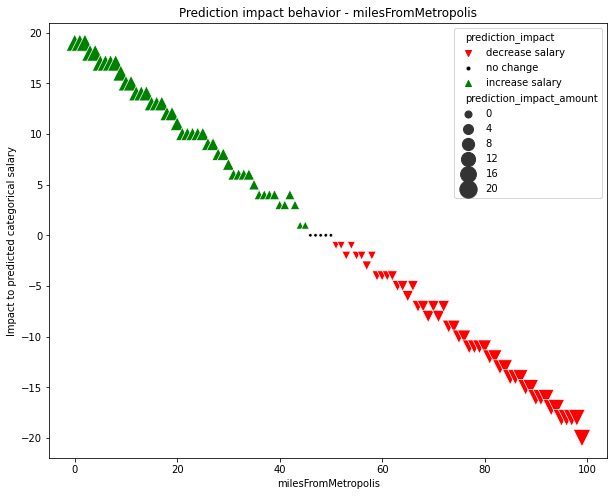

In [7]:
visualize_numeric_fit(example_baseline.fitted_numeric_diffs['milesFromMetropolis'])

The chart shows the behavior of the model, with respect to the `milesFromMetropolis` variable.

Values close to 50 `milesFromMetropolis` will have little to no impact on final salary amount. Values close to 0 or 100 will increase or decrease the predicted salary by the most, respectively.

## Final prediction process

Predicting on new data is done with the `.predict()` method, passing in a dataframe 

In [8]:
# Return all columns to get the intermediary variables that were created when including the numeric variables for prediction
example_preds = example_baseline.predict(test_salaries, return_all_cols = True)

Take a look at the resulting predictions and some of the columns that were created under the hood to help with calculations.

**Definitions of important intermediary columns**

New columns were added to the dataset to help with numeric prediction calculations, some notable ones are:
- **category_preds**: Predictions from the `fitted_category_salaries` attribute. It is mainly used for diagnostics and checking the influence of numeric variables
- **yearsExperience_diff** & **milesFromMetropolis_diff**: The joined values from the `fitted_numeric_diffs` attribute, used to add to the `category_preds`
- **combined_diff**: The combination of the two '_diff' columns, either added together or averaged
- **final_preds**: Salary prediction after row-wise summing `category_preds` and `combined_diff` columns

In [9]:
interesting_cols = ['jobType', 'yearsExperience', 'milesFromMetropolis',
                    'yearsExperience_diff', 'milesFromMetropolis_diff',
                    'category_preds_tmp', 'sum_numeric_diff', 'preds_with_sum', 'salary']
example_preds = example_preds[interesting_cols]

# Rename some columns for easier readability
col_rename = {
    'sum_numeric_diff': 'combined_diff',
    'category_preds_tmp': 'category_preds',
    'preds_with_sum': 'final_preds',
    'salary': 'salary_actual'
}
example_preds.rename(columns = col_rename, inplace = True)

# Inspect some random examples
example_preds.sample(5, random_state = 50)

,jobType,yearsExperience,milesFromMetropolis,yearsExperience_diff,milesFromMetropolis_diff,category_preds,combined_diff,final_preds,salary_actual
443822,JANITOR,3,15,-18.064561,13.599846,70.785181,-4.464715,66.320466,78
417907,CEO,17,50,9.979064,-0.567644,145.364115,9.411420,154.775536,206
165074,CTO,6,68,-12.127425,-7.143497,135.485534,-19.270922,116.214612,126
617693,MANAGER,13,89,1.857557,-15.506759,115.419110,-13.649202,101.769908,73
338229,JUNIOR,4,32,-16.023098,6.610019,95.341564,-9.413079,85.928484,101


From this sample, we can see that the influence of the numeric variables is helpful in some cases, but not in others where it shifts the prediction from the grouped average away from the actual salary.

**Interpreting the predictions:**

Looking at the `CEO` job in this case:  
1. Starting at the grouped average - 145k
2. Having 17 `yearsExperience` adds ~10k
3. Being 50 `milesFromMetropolis` wont change the prediction much (~ -0.5k)
4. The overall influence of the numeric variables is to increase the grouped average by ~9.4k
5. The final prediction is the `category_preds` + ~9.4k = ~155k, and is closer to the actual salary than just the grouped average from `category_preds`.

**Couple of thoughts to keep in mind when using this baseline model:**
1. Double check the errors when numerical variables are used in the prediction.  
- The `JANITOR` job in this case had a better predicted salary when only using the grouped average.
- Need to see how often the numeric variables can be wildly unhelpful.
   - Idea for a metric: How often is the error for predictions, with numeric variables included, larger than just using the categorical grouped average?  


2. Test 2 methods of combining the numeric diff columns - `sum` & `mean`.  
Averaging the numeric diff columns could help mitigate extreme edge cases.

    - It looks possible for the numeric variables to potentially have a huge influence on the final prediction.
    - If a job has 0 `yearsExperience` and is 99 `milesFromMetropolis` then the combined diff is about -40k
        - or  it could be +40k for values of 25 `yearsExperience` and 0 `milesFromMetropolis`.
    - If the `JANITOR` job here had 0 `yearsExperience` and 99 `milesFromMetropolis`, then the combined difference would reduce the grouped average by ~40k.

With a grouped average of ~71k in this case, that means the final prediction is less than half of the grouped average, and this seems a little extreme.    

# Find best baseline model parameters

Test all combinations of the 4 categorical variables that are in the data set. And for each combination evaluate different variations of whether or not the numeric variables are used and which ones.

#### All combinations of categorical variables

In [10]:
category_vars = ['jobType', 'degree', 'major', 'industry']

category_combos = []
for i in range(1,5):
    combos = combinations(category_vars, i)
    for j in combos:
        category_combos.append(list(j))

print(f"There are {len(category_combos)} combinations of categorical variables")
category_combos

There are 15 combinations of categorical variables


[['jobType'],
 ['degree'],
 ['major'],
 ['industry'],
 ['jobType', 'degree'],
 ['jobType', 'major'],
 ['jobType', 'industry'],
 ['degree', 'major'],
 ['degree', 'industry'],
 ['major', 'industry'],
 ['jobType', 'degree', 'major'],
 ['jobType', 'degree', 'industry'],
 ['jobType', 'major', 'industry'],
 ['degree', 'major', 'industry'],
 ['jobType', 'degree', 'major', 'industry']]

The values of the `model_variations` dictionary get passed to `BaselineModel()`. Each combination of categorical variables will therefore have multiple variations evaluated.

The variations:
- **only_categorical**: No numeric variables used for fitting, predictions will be made only with grouped categorical averages
- **add_yearsExperience**: The `yearsExperience` variable is used for fitting and added to the categorical average
- **add_milesFromMetropolis**: The `milesFromMetropolis` variable is used for fitting and added to the categorical average
- **add_both**: Both of the above numeric variables are used and the relative differences are combined and added to the categorical average
    + there are two models created for this variation. One combining the numeric fitted values using `sum`, and the other using `mean`

Best model score: 371.221955706675

Best model parameters:
{'category_vars': ['jobType', 'degree', 'major', 'industry'], 'numeric_vars': ['yearsExperience', 'milesFromMetropolis'], 'numeric_combo': 'sum'}





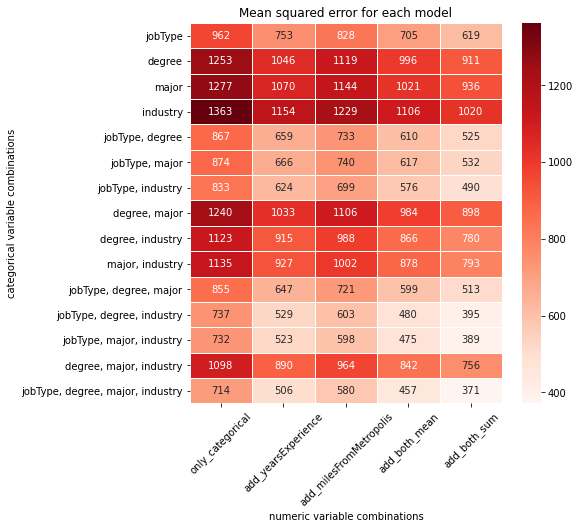

In [11]:
model_variations = {
    'only_categorical': None,
    'add_yearsExperience': 'yearsExperience',
    'add_milesFromMetropolis': 'milesFromMetropolis',
    'add_both': ['yearsExperience', 'milesFromMetropolis']
}
best_model = SelectBestModel(train_salaries, test_salaries, category_combos, model_variations)

#### Insights from testing 75 variations

- When using both numeric variables:
    - Using `sum` to combine the numeric diffs gives lower MSE than using `mean` - **in every instance**
- When using 1 numeric variable:
    - Using `yearsExperience` gives a lower MSE than `milesFromMetropolis` - **in every instance**
- When using 2 or 3 categorical variables:
    - When `jobType` is _not_ a part of the categorical variables, the MSE is much higher than when it is included

#### Double check the errors of the best model found

The variation of baseline with the lowest MSE incorporates numerical variables so we should make sure there aren't many cases of the numeric variables being wildly unhelpful.

Analysis:
- How often is the influence from the numeric variables unhelpful?
- metric: frequency of `salary_preds` variable having higher error than `category_preds_tmp`
    - **Unhelpful Percent:** `mean( abs(final_residuals) > abs(category_residuals) )`


In [12]:
best_baseline = best_model.best_model

# Make a couple functions here for getting residuals, and describing residuals

def get_residuals(data: pd.DataFrame) -> pd.DataFrame:
    """Given a dataframe of baseline predictions, return a dataframe with residual columns added
    
    must set return_all_cols=True when predicting
    """
    
    pass
    

best_preds = best_baseline.predict(test_salaries, numeric_combo = "sum", return_all_cols = True)
predicted_values = best_preds.loc[:, ['jobId', 'salary', 'salary_preds', 'category_preds_tmp']]

predicted_values['final_residuals'] = predicted_values.salary - predicted_values.salary_preds
predicted_values['category_residuals'] = predicted_values.salary - predicted_values.category_preds_tmp

# Use the absolute value to compare the magnitude of residual values
predicted_values['final_error_higher'] = predicted_values.final_residuals.abs() > predicted_values.category_residuals.abs()

predicted_values.head()

,jobId,salary,salary_preds,category_preds_tmp,final_residuals,category_residuals,final_error_higher
58414,JOB1362684466101,80,81.156102,90.559663,-1.156102,-10.559663,False
902618,JOB1362685310305,124,116.536360,107.421212,7.463640,16.578788,False
778824,JOB1362685186511,54,44.189400,75.211457,9.810600,-21.211457,False
187593,JOB1362684595280,80,80.366331,100.539788,-0.366331,-20.539788,False
574438,JOB1362684982125,89,115.844579,126.413793,-26.844579,-37.413793,False


In [29]:
predicted_values.final_residuals.describe()

count    150000.000000
mean         -0.024095
std          19.267170
min         -65.616577
25%         -14.037699
50%          -0.410280
75%          13.216444
max          81.857500
Name: final_residuals, dtype: float64

Frequency of unhelpful numeric variable influence: 36.07%



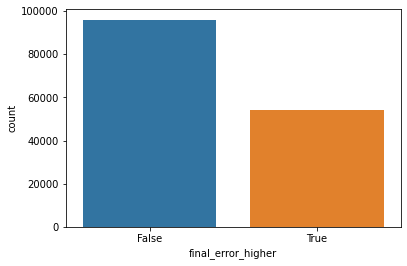

In [35]:
# Unhelpful %
unhelpful_percent = round(predicted_values.final_error_higher.mean() * 100, 2)
print(f"Frequency of unhelpful numeric variable influence: {unhelpful_percent}%\n")
sns.countplot(x = 'final_error_higher', data = predicted_values)
plt.show()

Queue the sad trombone sound, because that's a somewhat worrisome frequency.
- If there is a pattern to which jobs the numeric variables behave poorly for, this could indicate an area for improving the baseline. It also means that there are whole subgroups of similar jobs for which the model will reliably predict poorly on.

### Check for a pattern to unhelpful influence

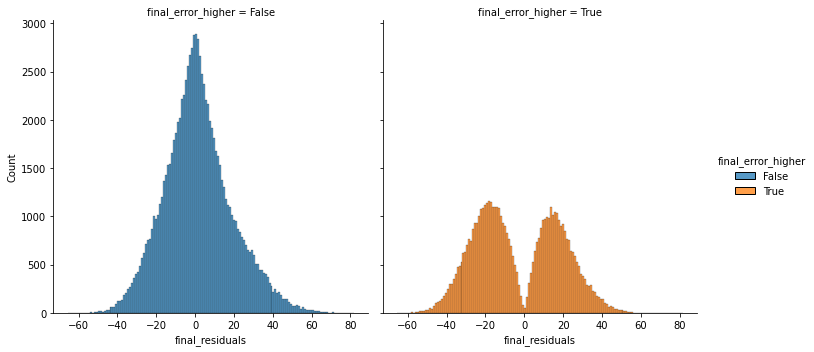

In [36]:
sns.displot(x = 'final_residuals', col='final_error_higher', data = predicted_values, kind = 'hist', hue = 'final_error_higher')
plt.show()

fitted values vs residuals

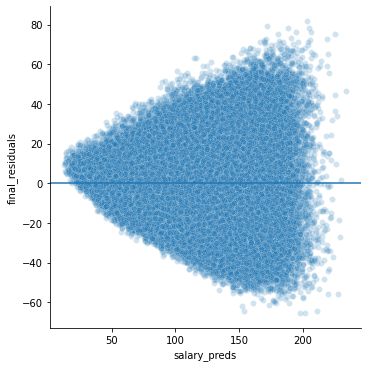

In [16]:
sns.relplot(x = 'salary_preds', y = 'final_residuals', data = predicted_values, alpha = 0.2)
plt.axhline(y = predicted_values.final_residuals.mean())

In [62]:
# Get standard error of the residuals when the model predicts 50k or 175k
for i in [50, 175]:
    std_error = predicted_values.final_residuals.loc[predicted_values.salary_preds.astype(int) == i].std()
    print(f"Std error of residuals when predicting {i}: {round(std_error, 2)}")

Std error of residuals when predicting 50: 8.63
Std error of residuals when predicting 175: 28.34


The standard error of the residuals grows as the model predicts higher salaries. When predicting 175 the standard error of the residuals is much higher than when predicting 50.